<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/NB11.%20Medical%20Instance%20Segmentation%20with%20Mask%20RCNN%20Custom%20Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Instance Segmentation with Mask R-CNN Custom Finetuning.


## 1. **Introduction**

[Mask R-CNN](https://viso.ai/deep-learning/mask-r-cnn/), an extension of [Faster R-CNN](http://paperswithcode.com/method/faster-r-cnn), enhances its predecessor's capabilities by incorporating a dedicated branch for predicting instance masks alongside the existing bounding box recognition mechanism. This modification enables Mask R-CNN to perform both object detection and pixel-level segmentation within a unified framework, making it a versatile tool for tasks requiring precise object delineation.

Faster R-CNN, initially designed primarily for accurate object localization using [region proposal networks (RPNs)](https://paperswithcode.com/method/rpn) and [RoIPool](http://paperswithcode.com/method/roi-pooling) for feature extraction, faced challenges in maintaining pixel-to-pixel alignment due to its coarse spatial quantization approach. This limitation becomes particularly apparent in tasks like instance segmentation, where exact spatial fidelity is critical.

To overcome this, Mask R-CNN introduces [RoIAlign](http://paperswithcode.com/method/roi-align), a refined operation that preserves precise spatial locations during feature extraction from region of interest (RoI) proposals. By eliminating the quantization step present in RoIPool, RoIAlign ensures that the features used for mask prediction align accurately with the corresponding regions in the input image, thereby improving segmentation quality significantly.

### Histopathology

Deep learning is increasingly being applied in histopathology, transforming the analysis of tissue samples, particularly for cancer `diagnosis and prognosis`. This technology helps in tasks like nuclei segmentation, tumor detection, and classification, often matching or exceeding the accuracy of trained pathologists. However, despite these advancements, the clinical implementation of these algorithms remains limited due to challenges in reproducibility, robustness, and the need for large annotated datasets.

Key applications include color normalization of `H&E-stained images` (Hematoxylin and Eosin (H&E) staining is a widely used method in histopathology for examining `tissue samples under a microscope`,) tissue and nuclei segmentation, and predictive modeling for cancer outcomes. While the potential is significant, widespread clinical adoption requires overcoming hurdles related to model validation, regulatory approval, and integration with existing diagnostic workflows.

For more detailed insights, you can explore resources like those from [MDPI](https://www.mdpi.com/2072-6694/14/5/1199), [PubMed](https://pubmed.ncbi.nlm.nih.gov/33990804/), and [Springer](https://link.springer.com/article/10.1007/s42979-023-02115-2).

### Dataset Overview: NuInsSeg

The [**NuInsSeg dataset**](https://www.kaggle.com/datasets/ipateam/nuinsseg/data) stands out as a comprehensive resource designed specifically for advancing semantic and instance segmentation tasks in histopathology. It comprises over 30,000 manually segmented nuclei originating from 31 different organs of human and mouse subjects, annotated from high-resolution H&E-stained whole slide images. These annotations serve as a foundational dataset for training and evaluating segmentation algorithms.

In addition to nuclei annotations, the dataset includes 665 image patches extracted from these whole slide images, encapsulating a wide range of tissue types and morphologies. This diversity ensures that segmentation models trained on NuInsSeg are robust and capable of handling various biological contexts.

One of the unique features of the NuInsSeg dataset is the provision of ambiguous area masks, which highlight regions where manual segmentation was deemed challenging or impractical. These masks offer insights into the complexities and nuances involved in real-world segmentation tasks, aiding in the development of more robust and generalizable segmentation algorithms.

Overall, the NuInsSeg dataset not only supports the development and benchmarking of instance segmentation algorithms but also contributes significantly to the advancement of automated histopathological analysis, potentially enhancing medical diagnostics and research outcomes.


## 2. **Setting our workspace up**

---
**Install Kaggle API Library**

---

In [1]:
!rm -rf /content/dataset-Nuclei
%pip install -q kaggle


---

**Upload your Kaggle API Key**

---

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


---

**Copy the API key to `~/.kaggle`**

---

In [3]:
# %%capture # util quieres capturar el output de la celda
%mkdir -p ~/.kaggle
%cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~

total 72
drwx------ 1 root root 4096 Jul 21 07:50 .
drwxr-xr-x 1 root root 4096 Jul 21 07:44 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Jul 18 13:39 .cache
drwxr-xr-x 3 root root 4096 Jul 18 13:39 .config
drwxr-xr-x 5 root root 4096 Jul 18 13:39 .ipython
drwx------ 1 root root 4096 Jul 18 13:39 .jupyter
drwxr-xr-x 2 root root 4096 Jul 21 07:50 .kaggle
drwxr-xr-x 2 root root 4096 Jul 21 07:44 .keras
drwx------ 3 root root 4096 Jul 18 13:14 .launchpadlib
drwxr-xr-x 1 root root 4096 Jul 18 13:39 .local
drwxr-xr-x 4 root root 4096 Jul 18 13:39 .npm
-rw-r--r-- 1 root root  161 Jul  9  2019 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf
-rw-r--r-- 1 root root  211 Jul 18 13:39 .wget-hsts


---
**List kaggle datasets nuiseng**

---

In [4]:
!kaggle datasets list -s "nuinsseg"

ref               title     size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------  --------  ----  -------------------  -------------  ---------  ---------------  
ipateam/nuinsseg  NuInsSeg   2GB  2023-06-12 14:49:00            838         15  0.875            


## 3. Download dataset

---

**Download ipateam/nuinsseg** (time 45 s)

---


In [5]:
%%time
# Download the dataset from Kaggle (2m.)

from  zipfile import ZipFile
import os

# First, ensure the 'dataset-Nuclei' directory exists

!mkdir -p ./dataset-Nuclei

# Download the dataset from Kaggle in dataset-Nuclei

!kaggle datasets download -d ipateam/nuinsseg -p ./dataset-Nuclei

# Unzip the dataset into the 'dataset-Nuclei' directory

with ZipFile('./dataset-Nuclei/nuinsseg.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset-Nuclei')

# or simply
#!unzip ./dataset-Nuclei/nuinsseg.zip -d ./dataset-Nuclei -q

# Remove the zip file after extraction (optional)

os.remove('./dataset-Nuclei/nuinsseg.zip')


Dataset URL: https://www.kaggle.com/datasets/ipateam/nuinsseg
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.51G/1.52G [00:20<00:00, 96.2MB/s]
100% 1.52G/1.52G [00:20<00:00, 81.3MB/s]
CPU times: user 12.2 s, sys: 4.64 s, total: 16.8 s
Wall time: 43.9 s


---
**List directory dataset**

---


In [6]:
# Install Pip Tree globally

!sudo apt install tree -q


!tree --dirsfirst -L 2  "dataset-Nuclei"

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (82.3 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 123586 files and directories currently installed.)
Preparing


Clean up of the Nuclei dataset. (It also can be downloaded from: https://www.kaggle.com/datasets/ipateam/nuinsseg?)resource=download

The dataset comes with a lot of subdirectories that can be very useful depending
on the task of your interest. For our Mask RCNN and Ultralytics YOLO training, we just
need the **raw images and labeled masks** that we will convert to appropriate formats.
So let us delete all unwanted data and keep only the `raw images, binary masks
and label mask`.

Keep the directories with names `'tissue images'`, `'mask binary without border'`, and `'label masks modify'`.

---

**Pruning innecesary sub-subdirectories**

---

In [7]:
import os
import shutil

base_directory = "dataset-Nuclei"
directories_to_keep = ['tissue images',
                       'mask binary without border',
                       'label masks modify']

#Iterate through each subdirs in base dir
for root_dir in os.listdir(base_directory):
  root_path = os.path.join(base_directory,root_dir)
  if os.path.isdir(root_path):
        # print(f"Processing: {root_path}")
    #List all subdirs inside the current root dir
    for sub_dir in os.listdir(root_path):
      sub_path = os.path.join(root_path, sub_dir)
      #If the subdirectory isn't in the keep list, delete it
      if os.path.isdir(sub_path) and sub_dir not in directories_to_keep:
        # print(f"Deleting: {sub_path}")
        shutil.rmtree(sub_path)
      elif os.path.isdir(sub_path):
        # print(f"Keeping: {sub_path}")
        pass



---


**List prunned directory**



---



In [8]:
!tree --dirsfirst -L 2  "dataset-Nuclei"

dataset-Nuclei
├── human bladder
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human brain
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human cardia
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human cerebellum
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human epiglottis
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human jejunum
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human kidney
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human liver
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human lung
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human melanoma
│   ├── label masks modify
│   ├── mask binary with


---

**Display some images from dataset**

---


Next code selects a certain number of images from a directory containing images of `tissue`, calculates the appropriate layout for subplots based on the number of images, and displays the images in the subplots using matplotlib.



 Displaying images from dataset-Nuclei/mouse heart/label masks modify 



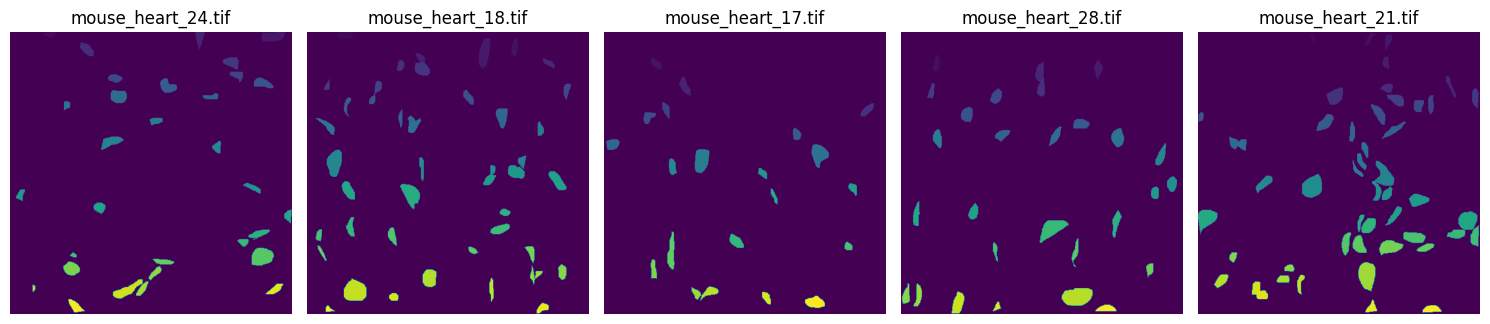


 Displaying images from dataset-Nuclei/mouse heart/tissue images 



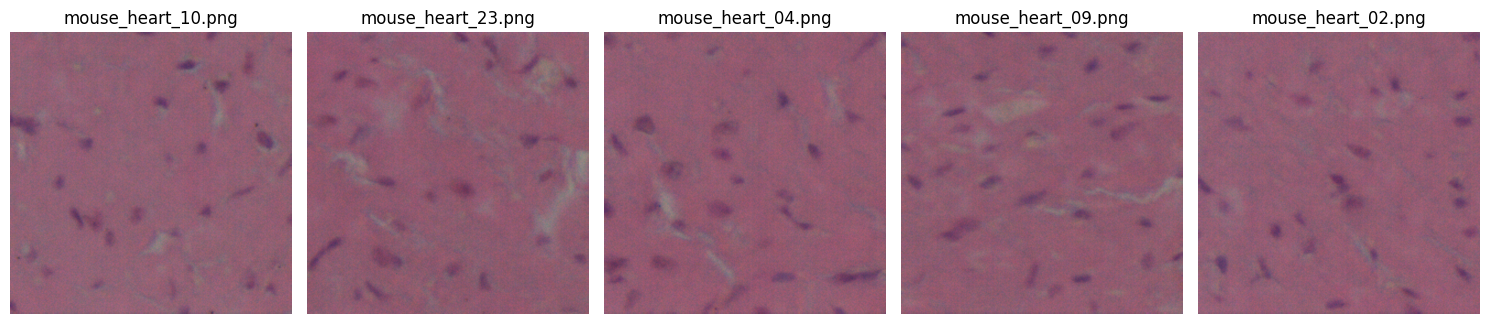


 Displaying images from dataset-Nuclei/mouse heart/mask binary without border 



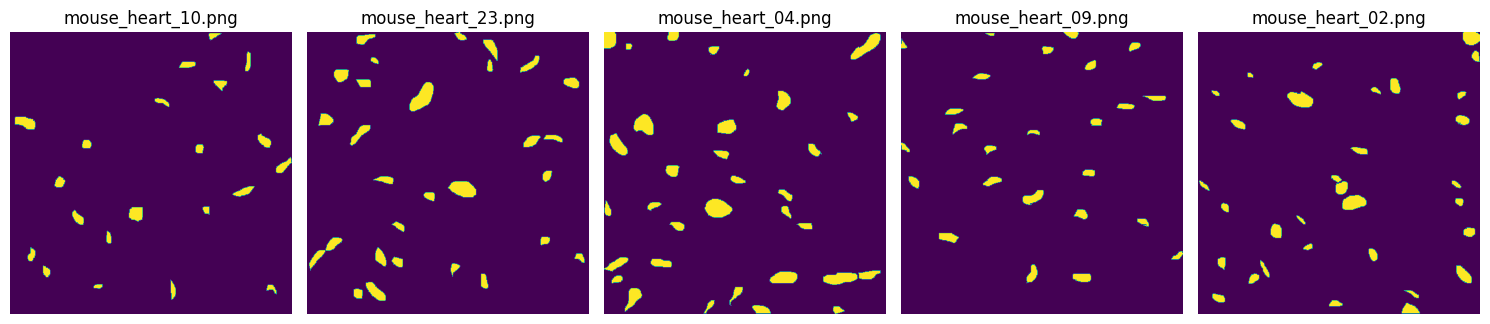

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing images
base_directory = "dataset-Nuclei"

# List of subdirectories in the base directory
subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# Select a random subdirectory from subdirectories
random_subdirectory = random.choice(subdirectories)
random_subdirectory_path = os.path.join(base_directory, random_subdirectory)

# List of sub-subdirectories in the random subdirectory
subsubdirectories = [d for d in os.listdir(random_subdirectory_path) if os.path.isdir(os.path.join(random_subdirectory_path, d))]

# Function to display images from a directory
def display_images_from_directory(directory, max_images=5):
    image_extensions = ['.tif', '.png']
    image_files = [f for f in os.listdir(directory) if any(f.endswith(ext) for ext in image_extensions)]

    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(image_files[:max_images]):  # Displaying up to max_images
        img_path = os.path.join(directory, image_file)
        img = Image.open(img_path)
        plt.subplot(1, max_images, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images from each sub-subdirectory
for subsubdirectory in subsubdirectories:
    subsubdirectory_path = os.path.join(random_subdirectory_path, subsubdirectory)
    print(f"\n Displaying images from {subsubdirectory_path} \n")
    display_images_from_directory(subsubdirectory_path)


We need to convert Label Masks to Coco Json single file annotation. We will convert our labeled mask image annotations to coco json
format so they can be used in training Mask R-CNN.

For it we will use:

1. **Function to Check if an Image is Binary:** 
This function checks whether an image is binary, meaning it only contains two distinct pixel values, usually 0 (black) and 255 (white).

2. **Function to Find Contours in a Binary Image and Convert Them to Polygons:**
This function extracts the contours from a binary image and converts them into polygons.


This code processes all images in the subdirectories and sub-subdirectories of the base directory, checks if they are binary, extracts polygons from the contours, and generates a coco.json file with the corresponding annotations.

---

**Mask_to_polygons_to COCO.json** (time 33s)

---

In [10]:
%%time
import os
import json
import numpy as np
import cv2
from PIL import Image

# Directory containing images
base_directory = "dataset-Nuclei"

# List of subdirectories in the base directory
subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# Function to check if an image is binary
def is_binary_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_np = np.array(img)
    unique_values = np.unique(img_np)
    return len(unique_values) == 2 and set(unique_values).issubset({0, 255})

# Function to find contours in a binary image and convert them to polygons
def get_polygons_from_mask(mask_image):
    mask_np = np.array(mask_image)
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [contour.flatten().tolist() for contour in contours if len(contour) >= 3]
    return polygons

# Initialize COCO structure
coco_data = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "nucleus", "supercategory": "object"}]
}

annotation_id = 1

# Process each subdirectory and its sub-subdirectories
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(base_directory, subdirectory)
    subsubdirectories = [d for d in os.listdir(subdirectory_path) if os.path.isdir(os.path.join(subdirectory_path, d))]

    for subsubdirectory in subsubdirectories:
        subsubdirectory_path = os.path.join(subdirectory_path, subsubdirectory)
        image_files = [f for f in os.listdir(subsubdirectory_path) if any(f.endswith(ext) for ext in ['.tif', '.png'])]

        for image_file in image_files:
            img_path = os.path.join(subsubdirectory_path, image_file)
            img = Image.open(img_path).convert('L')  # Convert to grayscale

            if is_binary_image(img_path):
                img_np = np.array(img)
                height, width = img_np.shape
                polygons = get_polygons_from_mask(img_np)

                if polygons:
                    coco_data["images"].append({
                        "id": len(coco_data["images"]) + 1,
                        "file_name": image_file,
                        "height": height,
                        "width": width
                    })

                    for polygon in polygons:
                        coco_data["annotations"].append({
                            "id": annotation_id,
                            "image_id": len(coco_data["images"]),
                            "category_id": 1,
                            "segmentation": [polygon],
                            "area": cv2.contourArea(np.array(polygon).reshape((-1, 2))),
                            "bbox": cv2.boundingRect(np.array(polygon).reshape((-1, 2))),
                            "iscrowd": 0
                        })
                        annotation_id += 1

# Save the data in COCO JSON format
with open("coco_annotations.json", "w") as outfile:
    json.dump(coco_data, outfile, indent=4)

print("Conversion complete. File saved as coco_annotations.json")


Conversion complete. File saved as coco_annotations.json
CPU times: user 31.1 s, sys: 798 ms, total: 31.9 s
Wall time: 33 s


---

**Libraries and auxiliar functions**

---

The function provided is designed to retrieve all image file paths within sub-subdirectories of a specified base directory.  The function searches the base directory for all images (in this case, with the `.png` extension) located within sub-subdirectories and returns a dictionary where the keys are the image file names and the values are their full paths. 

The function traverses a directory tree (up to two levels of subdirectories) to find all `.png` files and returns a dictionary containing the full paths of these files. This is useful when working with an image dataset organized into multiple folders.

In [11]:
import json
import os
import random
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Directory containing images
base_directory = "dataset-Nuclei"

# Function to get all images from all sub-subdirectories from the base directory
def get_all_image_paths(base_directory):
    image_paths = {}
    subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(base_directory, subdirectory)
        subsubdirectories = [d for d in os.listdir(subdirectory_path) if os.path.isdir(os.path.join(subdirectory_path, d))]
        for subsubdirectory in subsubdirectories:
            subsubdirectory_path = os.path.join(subdirectory_path, subsubdirectory)
            image_files = [f for f in os.listdir(subsubdirectory_path) if any(f.endswith(ext) for ext in ['.png', '.png'])]
            for image_file in image_files:
                image_path = os.path.join(subsubdirectory_path, image_file)
                image_paths[image_file] = image_path
    return image_paths

# Get all image paths
image_paths = get_all_image_paths(base_directory)


---

**Load COCO Annotations and Map Image IDs**

---

The next code snippet is used to process and organize data from a COCO (Common Objects in Context) dataset. The COCO dataset format is commonly used for tasks like object detection, segmentation, and image captioning. 

 The code loads COCO dataset annotations from a JSON file into a Python dictionary (`coco_data`). 
 
 Next, two dictionaries are created:
  - `image_id_to_data` maps image IDs to their full image data, allowing easy access to all image-related information by ID.
  - `file_name_to_id` maps file names to image IDs, allowing quick lookup of an image's ID based on its file name.

These mappings facilitate efficient retrieval and manipulation of image data within the COCO dataset, which can be especially useful for tasks like processing annotations, visualizing images, or linking images with their metadata.

In [12]:
# Load COCO annotations
with open('coco_annotations.json') as f:
    coco_data = json.load(f)

# Create dictionaries to map image IDs to image data and file names to image data
image_id_to_data = {img['id']: img for img in coco_data['images']}
file_name_to_id = {img['file_name']: img['id'] for img in coco_data['images']}

---

**Visualize Images and Annotations**

---

The next code defines a function that visualizes an image along with its corresponding annotations  (such as segmentation polygons) onto the image.

In [13]:
# Function to visualize a single image and its annotations
def visualize_image(image_data, annotations, ax):
    file_name = image_data['file_name'] # extracts the file name 
    img_path = image_paths.get(file_name) # retrieves the image's path

    if img_path is None:
        print(f"Image file {file_name} not found in any of the subdirectories.")
        return

    # Load the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Overlay the annotations
    for ann in annotations:
        # checks if the image_id matches the ID of the current image
        if ann['image_id'] == image_data['id']: 
            # extracts the segmentation data (assumed to be in polygon form)
            # and reshapes it into a 2D array of coordinates.
            polygon = np.array(ann['segmentation'][0]).reshape(-1, 2) 
            # A polygon is then created using Matplotlib's Polygon class
            poly = Polygon(polygon, facecolor='none', edgecolor='r')
            # overlaying the annotation on the image.
            ax.add_patch(poly)

    ax.set_title(f"ID: {image_data['id']}") # set the title


---

**Randomly Select and Visualize 10 Images**

---

Next provided code snippet is designed to randomly select and visualize a subset of images from a COCO dataset, along with their corresponding annotations. 

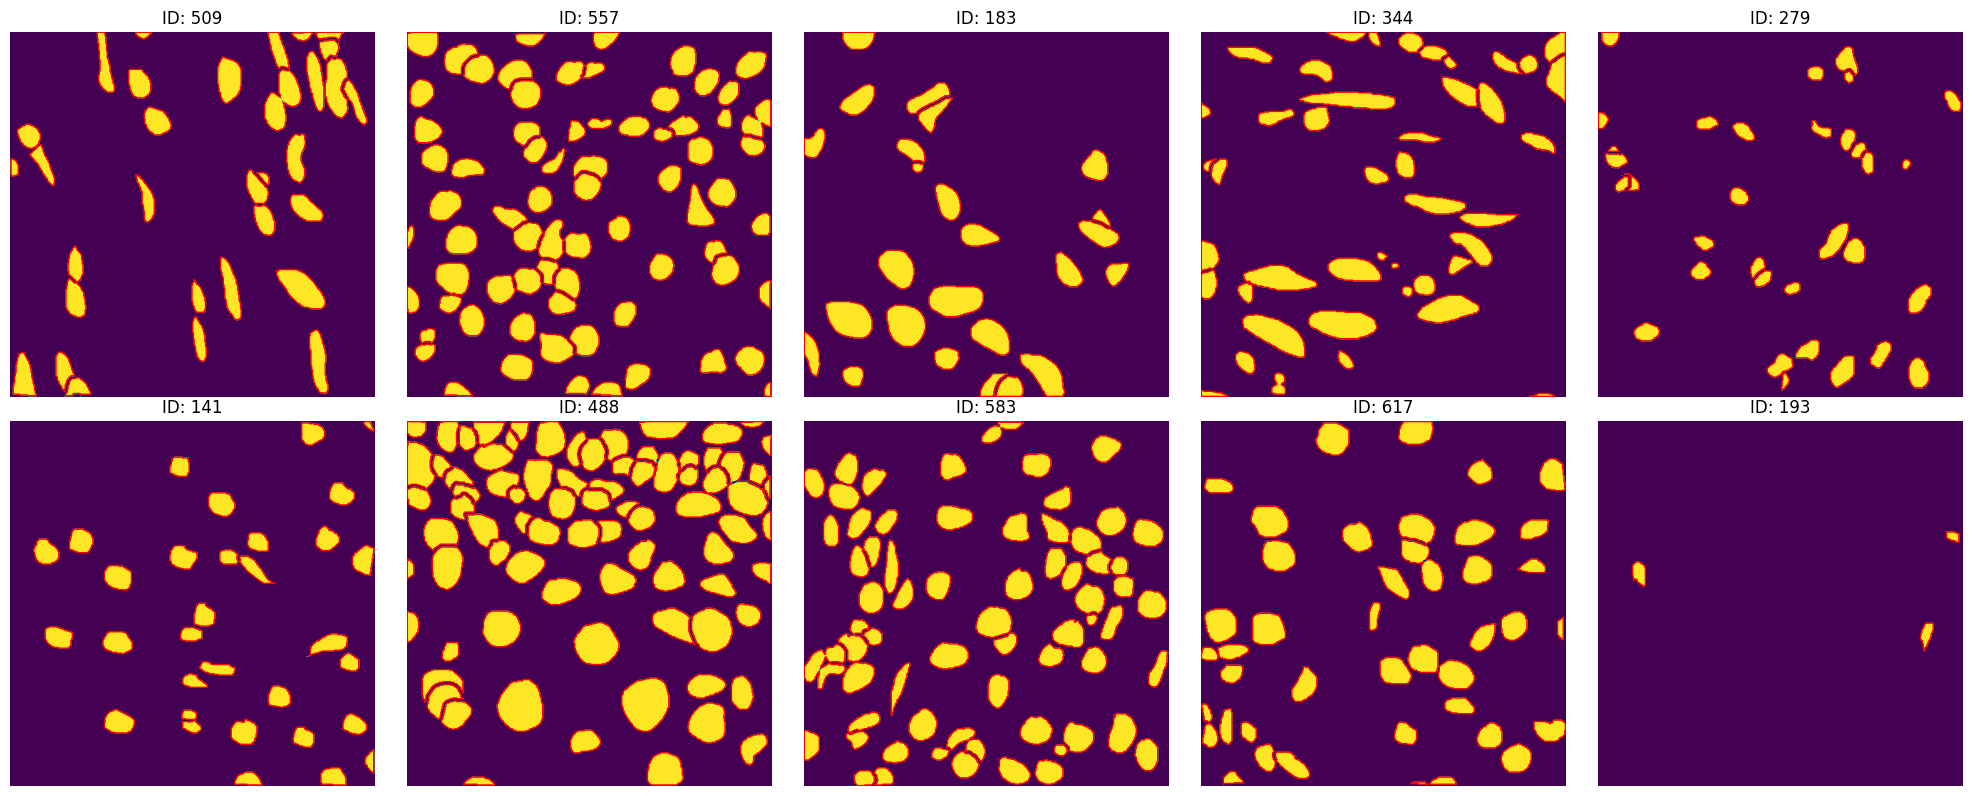

In [14]:
# Randomly select 10 images
random_images = random.sample(coco_data['images'], 10)

# Create a plot with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

# Visualize each selected image and its annotations
for ax, img_data in zip(axs, random_images):
    image_id = img_data['id']
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax)

plt.tight_layout()
plt.show()


---

**Print JSON File Lines**

---

Print the first few lines of the coco_annotations.json file

In [15]:
# Print the first few lines of the coco_annotations.json file
with open('coco_annotations.json', 'r') as f:
    for _ in range(24):  # Adjust the number of lines as needed
        print(f.readline().strip())


{
"images": [
{
"id": 1,
"file_name": "mouse_liver_23.png",
"height": 512,
"width": 512
},
{
"id": 2,
"file_name": "mouse_liver_22.png",
"height": 512,
"width": 512
},
{
"id": 3,
"file_name": "mouse_liver_21.png",
"height": 512,
"width": 512
},
{
"id": 4,
"file_name": "mouse_liver_17.png",
"height": 512,


---

**Print Polygon Coordinates**

---

Print some coordinates for 10 random images

In [17]:
# Function to print the polygon coordinates for a random image
def print_polygon_coordinates(image_data, annotations):
    print(f"Image ID: {image_data['id']}, File Name: {image_data['file_name']}")
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            print(f"  Annotation ID: {ann['id']}, Polygon Coordinates: {ann['segmentation'][0]}")


# Print polygon coordinates for the 10 random images
for img_data in random_images:
    image_id = img_data['id']
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    print_polygon_coordinates(img_data, annotations)

Image ID: 509, File Name: human_oesophagus_45.png
  Annotation ID: 19087, Polygon Coordinates: [92, 485, 91, 486, 87, 486, 83, 490, 83, 493, 82, 494, 82, 495, 81, 496, 81, 501, 80, 502, 80, 505, 78, 507, 78, 509, 77, 510, 77, 511, 78, 510, 88, 510, 87, 509, 89, 507, 98, 507, 100, 509, 101, 508, 112, 508, 113, 507, 113, 506, 112, 505, 112, 504, 111, 503, 111, 502, 110, 501, 110, 500, 109, 499, 109, 498, 108, 497, 108, 496, 107, 495, 107, 494, 101, 488, 100, 488, 97, 485]
  Annotation ID: 19088, Polygon Coordinates: [15, 450, 14, 451, 12, 451, 12, 454, 11, 455, 11, 456, 10, 457, 10, 461, 9, 462, 9, 465, 8, 466, 8, 478, 7, 479, 7, 482, 6, 483, 6, 491, 5, 492, 5, 496, 4, 497, 4, 508, 13, 508, 14, 509, 24, 509, 25, 510, 36, 510, 36, 507, 35, 506, 35, 503, 34, 502, 34, 497, 33, 496, 33, 494, 32, 493, 32, 489, 31, 488, 31, 485, 30, 484, 30, 478, 29, 477, 29, 472, 28, 471, 28, 467, 27, 466, 27, 465, 26, 464, 26, 462, 24, 460, 24, 459, 23, 458, 23, 457, 22, 456, 22, 455, 21, 454, 21, 453, 20, 4

## 4. Organize Image Data

---

**Split your images and annotations into train and val sets.**

---

In [18]:
# Function to split dataset into training and validation
def split_dataset(coco_data, split_ratio=0.8):
    # Randomly shuffle the images
    images = coco_data['images']
    random.shuffle(images)

    # Split images into train and validation sets
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Get image IDs for the split
    train_image_ids = {img['id'] for img in train_images}
    val_image_ids = {img['id'] for img in val_images}

    # Filter annotations based on the split image IDs
    train_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in train_image_ids]
    val_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in val_image_ids]

    # Create split data
    train_data = {
        'images': train_images,
        'annotations': train_annotations,
        'categories': coco_data['categories']
    }

    val_data = {
        'images': val_images,
        'annotations': val_annotations,
        'categories': coco_data['categories']
    }

    return train_data, val_data

# Split the dataset
train_data, val_data = split_dataset(coco_data, split_ratio=0.8)


---

**Create COCO Annotation Files for Train and Validation Sets**

---

In [19]:
# Define paths for the new COCO annotation files
train_annotation_path = 'train2017.json'
val_annotation_path = 'val2017.json'

# Save the annotations to JSON files
with open(train_annotation_path, 'w') as f:
    json.dump(train_data, f, indent=4)

with open(val_annotation_path, 'w') as f:
    json.dump(val_data, f, indent=4)

# Create directories for train and val datasets
os.makedirs('train2017', exist_ok=True)
os.makedirs('val2017', exist_ok=True)

# Function to move images to their respective directories
def move_images(data, image_paths, target_dir):
    for image in data['images']:
        image_file = image['file_name']
        if image_file in image_paths:
            source_path = image_paths[image_file]
            target_path = os.path.join(target_dir, image_file)
            shutil.move(source_path, target_path)
        else:
            print(f"Image {image_file} does not exist in image_paths and cannot be moved.")

# Move images to train2017 and val2017 directories
move_images(train_data, image_paths, 'train2017')
move_images(val_data, image_paths, 'val2017')


---

**Visualize 10 images from each directory (train2017 and val2017) to verify**

---

In [20]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.patches import Polygon

# Load COCO annotations for train and val sets
with open('train2017.json') as f:
    train_coco_data = json.load(f)

with open('val2017.json') as f:
    val_coco_data = json.load(f)

# Create dictionaries to map image IDs and file names to image data
train_file_name_to_data = {img['file_name']: img for img in train_coco_data['images']}
val_file_name_to_data = {img['file_name']: img for img in val_coco_data['images']}

# Function to get image path
def get_image_path(file_name, base_directory):
    return os.path.join(base_directory, file_name)


In [21]:
# Function to visualize a single image with annotations
def visualize_image(image_data, annotations, ax, base_directory):
    file_name = image_data['file_name']
    img_path = get_image_path(file_name, base_directory)

    if not os.path.isfile(img_path):
        print(f"Image file {file_name} not found.")
        return

    # Load the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Overlay annotations
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            # Draw polygons
            polygon = np.array(ann['segmentation'][0]).reshape(-1, 2)
            poly = Polygon(polygon, facecolor='none', edgecolor='r')
            ax.add_patch(poly)

    ax.set_title(f"ID: {image_data['id']}")


In [22]:
import random

# Function to select random images and their annotations
def get_random_images_and_annotations(coco_data, num_images=10):
    images = coco_data['images']
    random_images = random.sample(images, num_images)
    image_ids = {img['id'] for img in random_images}
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids]
    return random_images, annotations

# Select random images from train and val datasets
train_images, train_annotations = get_random_images_and_annotations(train_coco_data, num_images=10)
val_images, val_annotations = get_random_images_and_annotations(val_coco_data, num_images=10)


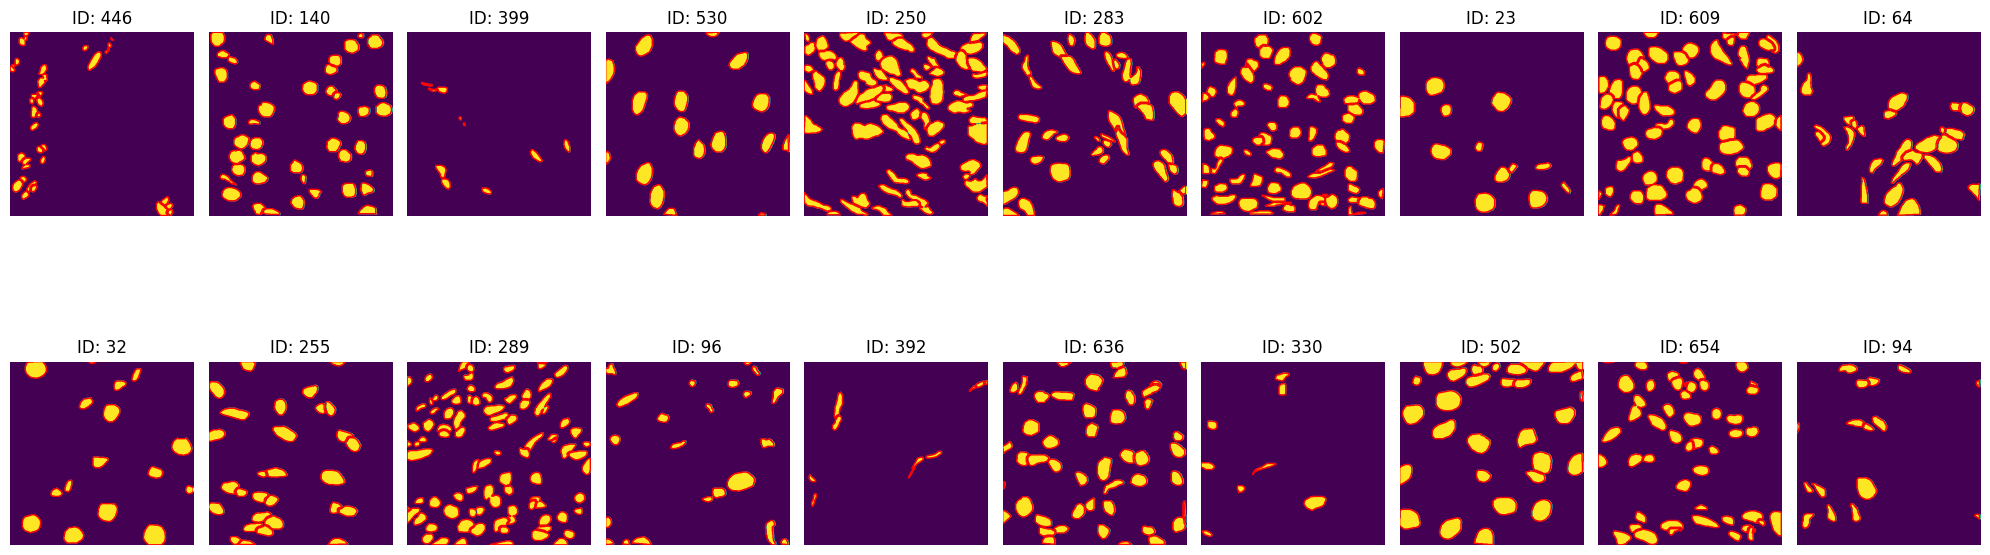

In [23]:
# Set base directories for train and val images
train_base_directory = 'train2017'
val_base_directory = 'val2017'

# Plot images from train and validation sets
fig, axs = plt.subplots(2, 10, figsize=(20, 8))

# Plot train images
for ax, img_data in zip(axs[0], train_images):
    image_id = img_data['id']
    annotations = [ann for ann in train_annotations if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax, train_base_directory)

# Plot val images
for ax, img_data in zip(axs[1], val_images):
    image_id = img_data['id']
    annotations = [ann for ann in val_annotations if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax, val_base_directory)

plt.tight_layout()
plt.show()


---
**List file names  in the train y val directories**

---

In [24]:
import os

# List files in the train2017 and val2017 directories
train_files = os.listdir(train_base_directory)
val_files = os.listdir(val_base_directory)

print("Files in train2017 directory:")
print(train_files[:10])  # Print first 10 files for quick checking

print("Files in val2017 directory:")
print(val_files[:10])  # Print first 10 files for quick checking


Files in train2017 directory:
['mouse_subscapula_42.png', 'human_testis_3.png', 'human_kidney_03.png', 'human_spleen_07.png', 'mouse_muscle_tibia_09.png', 'human_jejunum_10.png', 'mouse_liver_23.png', 'human_oesophagus_34.png', 'human_cerebellum_3.png', 'human_salivory_33.png']
Files in val2017 directory:
['mouse_subscapula_02.png', 'mouse_spleen_02.png', 'human_salivory_38.png', 'human_liver_09.png', 'human_umbilical_cord_08.png', 'human_rectum_1.png', 'human_cerebellum_10.png', 'mouse_spleen_01.png', 'human_oesophagus_11.png', 'mouse_kidney_15.png']


## 5. Fine-tune Mask R-CNN for medical instance segmentation

Detectron2 is an advanced open-source framework developed by Meta (formerly Facebook) for computer vision tasks, particularly object detection and image segmentation. Built on top of PyTorch, it is designed to be modular, flexible, and scalable, making it suitable for a wide range of applications in fields like autonomous driving, robotics, and medical imaging.

### Key Features and Capabilities:
1. **Object Detection and Segmentation**: Detectron2 excels at detecting and segmenting objects within images, including complex tasks like: 
   1. Instance segmentation: Instance segmentation is the task of detecting objects within an image, classifying them, and segmenting each instance of the object individually) and 
   2. Panoptic segmentation: Instance segmentation plus semantic segmentation. For example; in a panoptic segmentation of a street scene, the algorithm would label each car separately (instance segmentation) and also label the road, sky, and buildings (semantic segmentation.))

2. **Modular Architecture**: The framework is highly modular, allowing users to customize and configure various components such as backbone networks, head architectures, and data pipelines to fit specific use cases.

3. **Pre-trained Models**: Detectron2 provides numerous pre-trained models that can be fine-tuned on custom datasets, which significantly speeds up development.

4. **High Performance**: Detectron2 is optimized for both speed and accuracy, supporting distributed training and inference on GPUs to handle large datasets efficiently.

5. **Community and Support**: With a large and active community, Detectron2 benefits from continuous updates, bug fixes, and the addition of new features. Extensive documentation and tutorials are available to help users get started and solve specific challenges.

### Applications:
- **Autonomous Driving**: Detectron2 is used to detect and classify objects such as pedestrians, vehicles, and road signs, enabling safer navigation for self-driving cars.
- **Robotics**: In robotics, it aids in object recognition and manipulation, essential for tasks like sorting items on assembly lines or navigating environments.
- **Medical Imaging**: Detectron2 is employed in identifying tumors or other abnormalities in medical scans, enhancing diagnostic accuracy.

For more detailed guidance, you can refer to the [official GitHub repository](https://github.com/facebookresearch/detectron2) or [this comprehensive guide](https://viso.ai/computer-vision/detectron2/).




First, install Detectron2 and other necessary dependencies.



---
**Set up the environment** (time 6 minutes aprox)

---

In [25]:
%%time
!pip install -q torch torchvision
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q opencv-python
!pip install -q matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
CPU times: user 2.32 s, sys: 318 ms, total: 2.64 s
Wall time: 6min 3s


---
**Configure the Mask R-CNN model**

---

Use a Python script to configure and train the Mask R-CNN model with detectron2.

In [ ]:
import os
import json
import random
import numpy as np
import cv2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances

# Register COCO datasets
register_coco_instances("nuclei_train", {}, "train2017.json", "train2017")
register_coco_instances("nuclei_val", {}, "val2017.json", "val2017")

# Configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nuclei_train",)
cfg.DATASETS.TEST = ("nuclei_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000    # Adjust this as needed
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Adjust this as needed
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (e.g., Nucleus)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

This Python code sets up and configures a deep learning model for instance segmentation using the Detectron2 library, a popular framework developed by Facebook AI Research (FAIR) for object detection and segmentation tasks. The code is specifically designed to work with a COCO-format dataset that includes images of nuclei, which suggests that it’s being used for a biomedical image analysis task (e.g., identifying and segmenting cell nuclei in microscope images).

Here’s a step-by-step explanation of what each part of the code does:

### 1. **Importing Libraries**
   ```python
   import os
   import json
   import random
   import numpy as np
   import cv2
   import torch
   from detectron2 import model_zoo
   from detectron2.engine import DefaultTrainer, DefaultPredictor
   from detectron2.config import get_cfg
   from detectron2.data import MetadataCatalog, DatasetCatalog
   from detectron2.utils.visualizer import Visualizer
   from detectron2.structures import BoxMode
   from detectron2.data.datasets import register_coco_instances
   ```
   - **os**: Provides functions to interact with the operating system, like creating directories.
   - **json**: Used to handle JSON data, such as reading dataset annotations.
   - **random**: Used for generating random numbers or making random selections.
   - **numpy (np)**: A library for numerical operations, particularly useful for array manipulations.
   - **cv2**: OpenCV library for image processing tasks.
   - **torch**: PyTorch, the deep learning framework underlying Detectron2.
   - **detectron2 modules**: Importing various components from Detectron2 to set up, train, and use the model.

### 2. **Registering COCO Datasets**
   ```python
   register_coco_instances("nuclei_train", {}, "train2017.json", "train2017")
   register_coco_instances("nuclei_val", {}, "val2017.json", "val2017")
   ```
   - **register_coco_instances**: This function registers the training and validation datasets with Detectron2.
   - `"nuclei_train"` and `"nuclei_val"`: Names given to the training and validation datasets.
   - `"train2017.json"` and `"val2017.json"`: Paths to the annotation files in COCO format.
   - `"train2017"` and `"val2017"`: Directories containing the corresponding images.

   By registering these datasets, Detectron2 knows where to find the images and annotations during training and evaluation.

### 3. **Model Configuration**
   ```python
   cfg = get_cfg()
   cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
   ```
   - **cfg = get_cfg()**: Initializes a default configuration object for Detectron2.
   - **merge_from_file**: Loads and merges configuration settings from a predefined configuration file for a Mask R-CNN model with a ResNet-50 backbone and FPN (Feature Pyramid Network), trained on COCO.

### 4. **Dataset and Model Setup**
   ```python
   cfg.DATASETS.TRAIN = ("nuclei_train",)
   cfg.DATASETS.TEST = ("nuclei_val",)
   cfg.DATALOADER.NUM_WORKERS = 2
   cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
   cfg.SOLVER.IMS_PER_BATCH = 2
   cfg.SOLVER.BASE_LR = 0.00025
   cfg.SOLVER.MAX_ITER = 1000    # Adjust this as needed
   cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Adjust this as needed
   cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (e.g., Nucleus)
   ```
   - **cfg.DATASETS.TRAIN / TEST**: Specifies the datasets to be used for training and testing.
   - **cfg.DATALOADER.NUM_WORKERS = 2**: Sets the number of data loading workers. Increasing this number can speed up data loading.
   - **cfg.MODEL.WEIGHTS**: Specifies the pre-trained model weights to initialize the model.
   - **cfg.SOLVER.IMS_PER_BATCH = 2**: The number of images to process in a single batch.
   - **cfg.SOLVER.BASE_LR = 0.00025**: Sets the base learning rate for training.
   - **cfg.SOLVER.MAX_ITER = 1000**: Sets the maximum number of iterations (steps) for training.
   - **cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64**: Number of regions of interest (ROIs) to sample per image during training.
   - **cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1**: Specifies that there is only one class to detect (e.g., the nuclei).

### 5. **Output Directory Creation**
   ```python
   os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
   ```
   - **os.makedirs**: Creates the directory specified by `cfg.OUTPUT_DIR` (the directory where model outputs like checkpoints and logs will be saved). The `exist_ok=True` argument ensures that no error is raised if the directory already exists.

### Summary:
This code sets up the environment for training an instance segmentation model using Detectron2. It registers the training and validation datasets in COCO format, configures the model (Mask R-CNN with a ResNet-50 backbone), and prepares it for training by specifying various parameters like the learning rate, batch size, and number of classes. The final step ensures that an output directory is created to save the results of the training process.

## 6. **Train detectron2**

---
**Train the model**

---

In [26]:
%%time

# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Save the final weights
final_weights_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
torch.save(trainer.model.state_dict(), final_weights_path)

[07/21 07:58:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 133MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/21 07:58:38 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/21 07:58:54 d2.utils.events]:  eta: 0:06:15  iter: 19  total_loss: 3.565  loss_cls: 0.8538  loss_box_reg: 0.725  loss_mask: 0.6863  loss_rpn_cls: 1.205  loss_rpn_loc: 0.1123    time: 0.3978  last_time: 0.3442  data_time: 0.0343  last_data_time: 0.0176   lr: 4.9953e-06  max_mem: 1993M
[07/21 07:59:08 d2.utils.events]:  eta: 0:05:32  iter: 39  total_loss: 2.997  loss_cls: 0.7621  loss_box_reg: 0.7466  loss_mask: 0.6726  loss_rpn_cls: 0.6583  loss_rpn_loc: 0.1267    time: 0.3549  last_time: 0.3738  data_time: 0.0103  last_data_time: 0.0063   lr: 9.9902e-06  max_mem: 1993M
[07/21 07:59:14 d2.utils.events]:  eta: 0:05:20  iter: 59  total_loss: 2.29  loss_cls: 0.6513  loss_box_reg: 0.8051  loss_mask: 0.6418  loss_rpn_cls: 0.1154  loss_rpn_loc: 0.1027    time: 0.3438  last_time: 0.3425  data_time: 0.0140  last_data_time: 0.0135   lr: 1.4985e-05  max_mem: 1993M
[07/21 07:59:20 d2.utils.events]:  eta: 0:05:07  iter: 79  total_loss: 2.113  loss_cls: 0.5736  loss_box_reg: 0.7575  loss_mask: 0

This output is a detailed summary of the architecture of a neural network model used for object detection and segmentation, specifically a variant of the Mask R-CNN model implemented with the Detectron2 framework. On the other hand, the logs indicate that the training is proceeding as expected, with losses decreasing and the model using an appropriate amount of GPU memory. The warnings about shape mismatches are normal and expected when fine-tuning a model on a different number of classes than it was originally trained on.

1. **Model Structure: GeneralizedRCNN**
   - **GeneralizedRCNN** is the base class for many models, including Mask R-CNN. It includes several sub-modules like the backbone, region proposal network (RPN), and ROI heads for bounding box regression and segmentation.

2. **Backbone: FPN with ResNet**
   - **FPN (Feature Pyramid Network)**:
     - The FPN enhances the feature maps extracted from the backbone, allowing the model to detect objects at multiple scales.
     - It uses several lateral and output convolution layers to merge features from different stages of the ResNet backbone.
   - **ResNet (Residual Network)**:
     - A ResNet is used as the backbone, with five stages (`res2` to `res5`), each stage containing multiple **BottleneckBlocks**.
     - **BottleneckBlock**: A block with three convolution layers, each followed by a normalization layer (**FrozenBatchNorm2d**). These blocks help in deeper architectures without vanishing gradients.

3. **Proposal Generator: RPN**
   - **RPN (Region Proposal Network)**:
     - Generates region proposals (potential object locations) which the ROI heads process.
     - **StandardRPNHead**: Includes a 3x3 convolution layer followed by two separate layers for objectness (foreground/background) classification (`objectness_logits`) and bounding box regression (`anchor_deltas`).
   - **Anchor Generator**: Generates anchors at different scales and aspect ratios for the RPN.

4. **ROI Heads: StandardROIHeads**
   - **ROI Pooler**:
     - **ROIPooler**: Extracts fixed-size feature maps for each proposed region using the **ROIAlign** operation at different levels of the FPN.
   - **Box Head (FastRCNNConvFCHead)**:
     - Processes the pooled features through fully connected layers (`fc1`, `fc2`) to predict object classes (`cls_score`) and refine bounding boxes (`bbox_pred`).
   - **Mask Head (MaskRCNNConvUpsampleHead)**:
     - Predicts segmentation masks for the detected objects.
     - Consists of several convolutional layers with ReLU activations, followed by a transpose convolution (`deconv`) to upsample the mask predictions.

5. **Output Layers**
   - **cls_score**: The final classification layer outputting the probability of each class.
   - **bbox_pred**: The layer that outputs the refined coordinates for bounding boxes.
   - **mask predictor**: The final convolutional layer that outputs the binary mask for each object.


6. **Data Loading and Preparation**:
   - The training data is loaded from a COCO format dataset (`train2017.json`), consisting of 532 images.
   - The dataset includes 21,694 instances of the category "nucleus."
   - Augmentations applied during training include resizing the shortest edge (between 640 and 800 pixels) and random horizontal flipping.
   - The dataset is serialized for faster access during training.

7. **Model Initialization**:
   - A pre-trained Mask R-CNN model (`mask_rcnn_R_50_FPN_3x`) is being fine-tuned on the new dataset.
   - Warnings indicate that certain layers' shapes in the pre-trained model do not match the target model. This is expected since the number of classes is different (2 in your case, instead of the original 81).
   - These mismatches are for the `roi_heads` components, responsible for class prediction, bounding box regression, and mask prediction. Since the dataset has a single class (excluding the background), many parameters are ignored.

8. **Training Loop**:
   - The training loop starts with the first iteration (`iter 0`).
   - Early iterations show decreasing `total_loss`, `loss_cls` (classification loss), `loss_box_reg` (box regression loss), `loss_mask` (mask loss), `loss_rpn_cls` (RPN classification loss), and `loss_rpn_loc` (RPN localization loss). This indicates that the model is learning and improving as the training progresses.
   - The ETA (estimated time of arrival) for training completion is dynamically adjusted as iterations progress.
   - The `max_mem` value (~2050MB) shows the maximum memory utilized during the training, which remains relatively stable.

9. **Learning Rate**:
   - The learning rate (`lr`) starts at a very low value and gradually increases, which is typical in a warm-up phase for training deep learning models.


## 7.  **Evaluate the model**

---
**Evaluate the model**

---

In [27]:
# Load the trained model
cfg.MODEL.WEIGHTS = final_weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Evaluate the model on the validation dataset
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("nuclei_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "nuclei_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


[07/21 08:04:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [07/21 08:04:33 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/21 08:04:33 d2.data.datasets.coco]: Loaded 133 images in COCO format from val2017.json
[07/21 08:04:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/21 08:04:33 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/21 08:04:33 d2.data.common]: Serializing 133 elements to byte tensors and concatenating them all ...
[07/21 08:04:34 d2.data.common]: Serialized dataset takes 1.64 MiB
[07/21 08:04:34 d2.evaluation.evaluator]: Start inference on 133 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/21 08:04:35 d2.evaluation.evaluator]: Inference done 11/133. Dataloading: 0.0077 s/iter. Inference: 0.0925 s/iter. Eval: 0.0136 s/iter. Total: 0.1138 s/iter. ETA=0:00:13
[07/21 08:04:41 d2.evaluation.evaluator]: Inference done 54/133. Dataloading: 0.0043 s/iter. Inference: 0.0919 s/iter. Eval: 0.0226 s/iter. Total: 0.1189 s/iter. ETA=0:00:09
[07/21 08:04:46 d2.evaluation.evaluator]: Inference done 84/133. Dataloading: 0.0064 s/iter. Inference: 0.0995 s/iter. Eval: 0.0321 s/iter. Total: 0.1382 s/iter. ETA=0:00:06
[07/21 08:04:51 d2.evaluation.evaluator]: Inference done 103/133. Dataloading: 0.0073 s/iter. Inference: 0.1163 s/iter. Eval: 0.0422 s/iter. Total: 0.1661 s/iter. ETA=0:00:04
[07/21 08:04:56 d2.evaluation.evaluator]: Inference done 125/133. Dataloading: 0.0077 s/iter. Inference: 0.1196 s/iter. Eval: 0.0502 s/iter. Total: 0.1777 s/iter. ETA=0:00:01


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07/21 08:04:57 d2.evaluation.evaluator]: Total inference time: 0:00:22.678440 (0.177175 s / iter per device, on 1 devices)
[07/21 08:04:57 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:15 (0.118746 s / iter per device, on 1 devices)
[07/21 08:04:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/21 08:04:58 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[07/21 08:04:58 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[07/21 08:04:58 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[07/21 08:04:58 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.30 seconds.
[07/21 08:04:58 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[07/21 08:04:58 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.04 seconds.
 Average Precision  (AP)

The provided output details the evaluation results of an object detection and segmentation model using the COCO dataset. The evaluation is conducted for two types of predictions: bounding boxes (bbox) and segmentations (segm). Below is a detailed explanation of each part of the results:

### Bounding Box (bbox) Evaluation:

1. **AP (Average Precision)**: The average precision considering various Intersection over Union (IoU) thresholds from 0.50 to 0.95 in increments of 0.05.
   - **AP**: 71.386
   - **AP50**: 80.704 (precision at IoU of at least 0.50)
   - **AP75**: 77.212 (precision at IoU of at least 0.75)
   - **APs**: 72.373 (precision for small objects)
   - **APm**: 69.686 (precision for medium objects)
   - **APl**: 0.000 (precision for large objects)

### Segmentation (segm) Evaluation:

The segmentation evaluation follows a similar approach to the bounding box evaluation.

2. **AP (Average Precision)**: The average precision considering various IoU thresholds from 0.50 to 0.95.
   - **AP**: 72.923
   - **AP50**: 83.156 (precision at IoU of at least 0.50)
   - **AP75**: 77.301 (precision at IoU of at least 0.75)
   - **APs**: 71.788 (precision for small objects)
   - **APm**: 76.417 (precision for medium objects)
   - **APl**: 0.000 (precision for large objects)

### Detailed Results:

3. **Loading and preparing results**: A quick process that took 0.10 seconds to load and prepare the results for evaluation.
4. **Creating index**: Building the index for fast access to data, completed almost instantly.
5. **Evaluating annotation type 'segm'**: The evaluation of segmentation annotations completed in 0.52 seconds.
6. **Accumulating evaluation results**: This process aggregates and summarizes the evaluation results, completed in 0.02 seconds.

### Average Precision (AP) and Average Recall (AR):

- **Average Precision (AP)**:
  - For all areas (small, medium, large) and a range of IoU from 0.50 to 0.95:
    - **AP**: 0.729
  - At IoU of 0.50:
    - **AP50**: 0.832
  - At IoU of 0.75:
    - **AP75**: 0.773
  - For small objects:
    - **APs**: 0.718
  - For medium objects:
    - **APm**: 0.764
  - For large objects:
    - **APl**: 0.000

- **Average Recall (AR)**:
  - For all areas and a range of IoU from 0.50 to 0.95:
    - **AR** with 1 maximum detection (maxDets=1): 0.022
    - **AR** with 10 maximum detections (maxDets=10): 0.203
    - **AR** with 100 maximum detections (maxDets=100): 0.779
  - For small objects:
    - **ARs**: 0.774
  - For medium objects:
    - **ARm**: 0.790
  - For large objects:
    - **ARl**: 0.000

### Final Summary:

The evaluation shows that the model has good precision and recall in most categories, especially for small and medium objects. However, the precision and recall for large objects (APl) are zero, indicating that the model does not detect or segment large objects well in this specific dataset.

**Ordered Results:**

```plaintext
OrderedDict([
    ('bbox', {
        'AP': 71.38589058162736,
        'AP50': 80.70393943819066,
        'AP75': 77.21247524714379,
        'APs': 72.37291319676002,
        'APm': 69.68579424161346,
        'APl': 0.0
    }),
    ('segm', {
        'AP': 72.92266914514549,
        'AP50': 83.15554978747116,
        'AP75': 77.30053165952862,
        'APs': 71.78824278403566,
        'APm': 76.41660160594263,
        'APl': 0.0
    })
])
```

This summary provides the exact values of the evaluation metrics for both bounding boxes and segmentations, highlighting the performance differences across different object size categories.

### Display results

---
**Visualize Results**

---

[07/21 08:05:00 d2.data.datasets.coco]: Loaded 133 images in COCO format from val2017.json


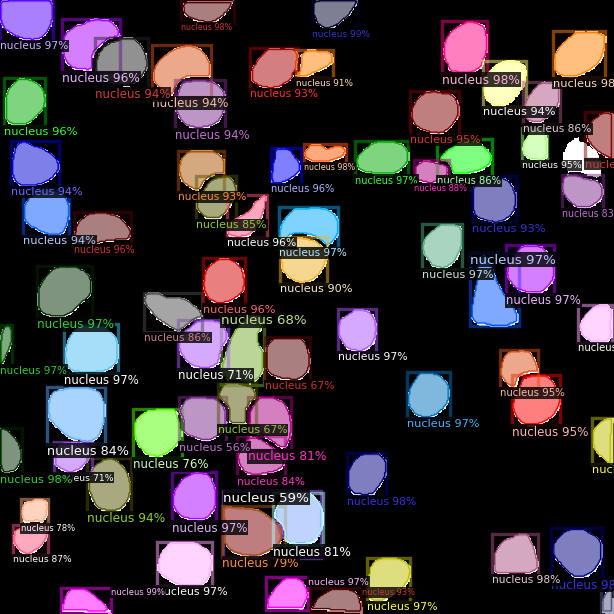

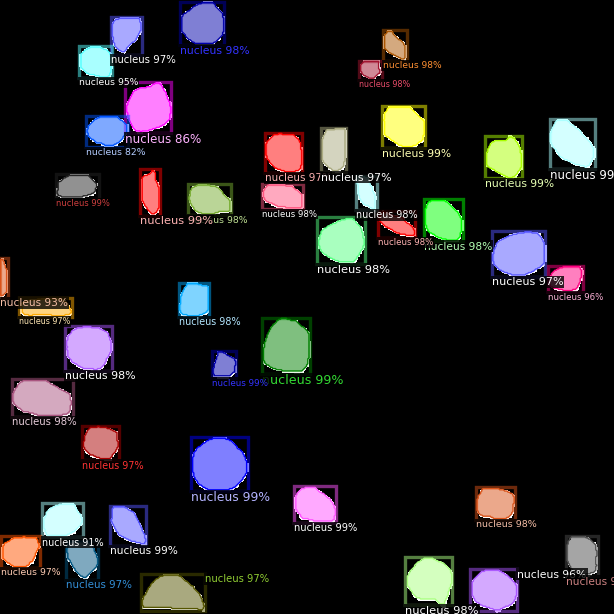

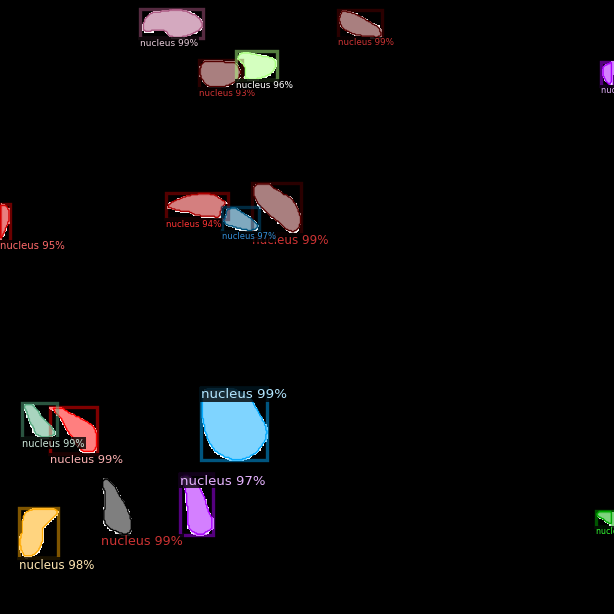

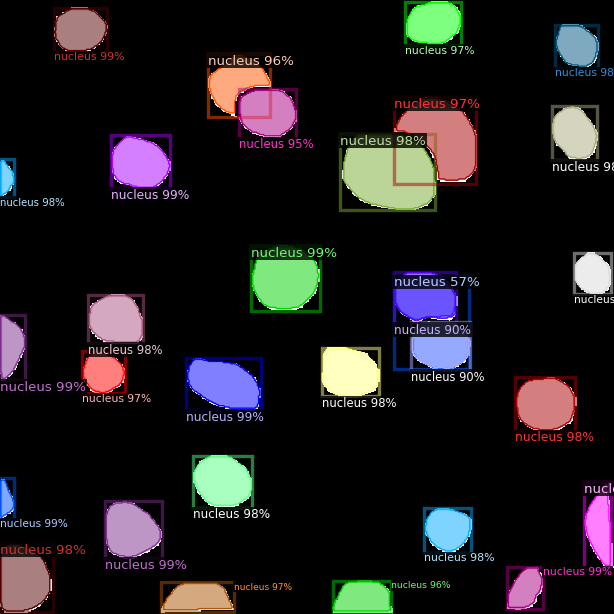

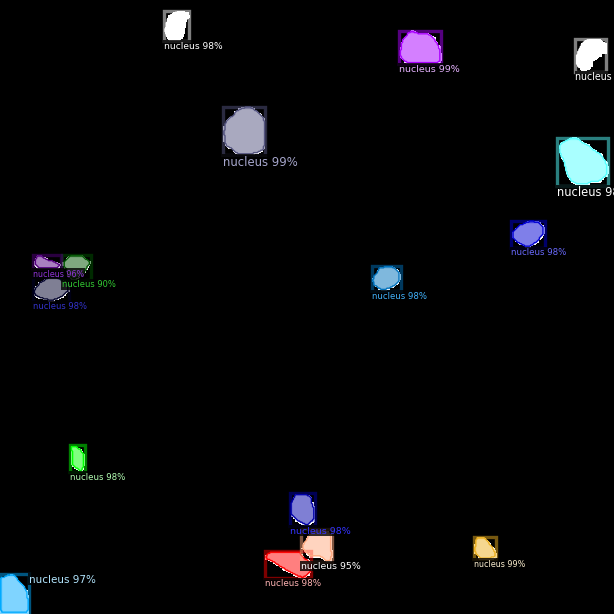

In [28]:
from google.colab.patches import cv2_imshow

dataset_dicts = DatasetCatalog.get("nuclei_val")

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get("nuclei_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.waitKey(0)
cv2.destroyAllWindows()


## 8. **Predictions** (Inference)

---
**Prediction over data** (5 images)

---

[07/21 08:05:04 d2.data.datasets.coco]: Loaded 133 images in COCO format from val2017.json


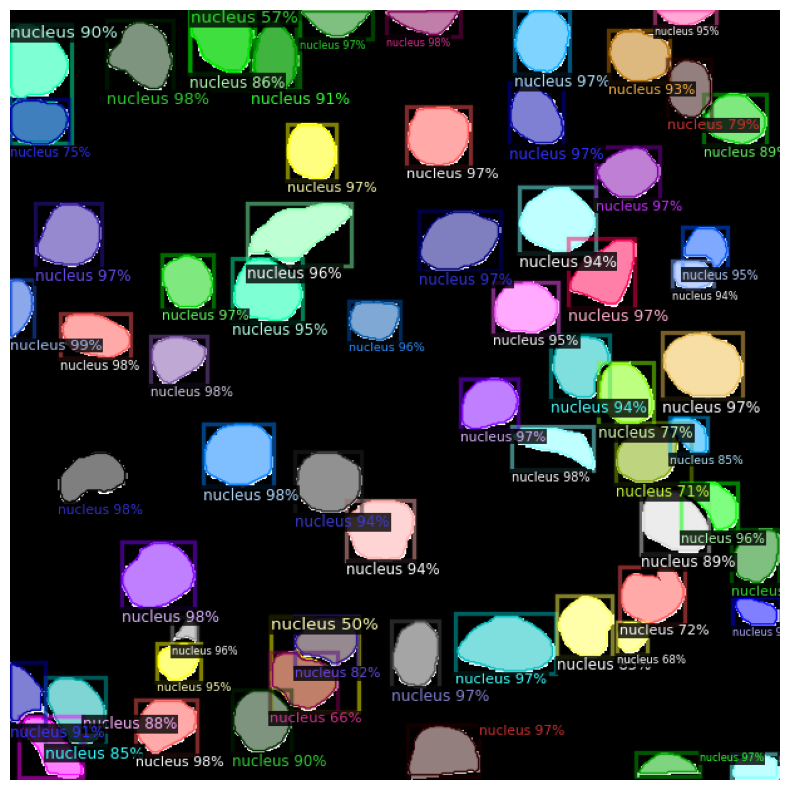

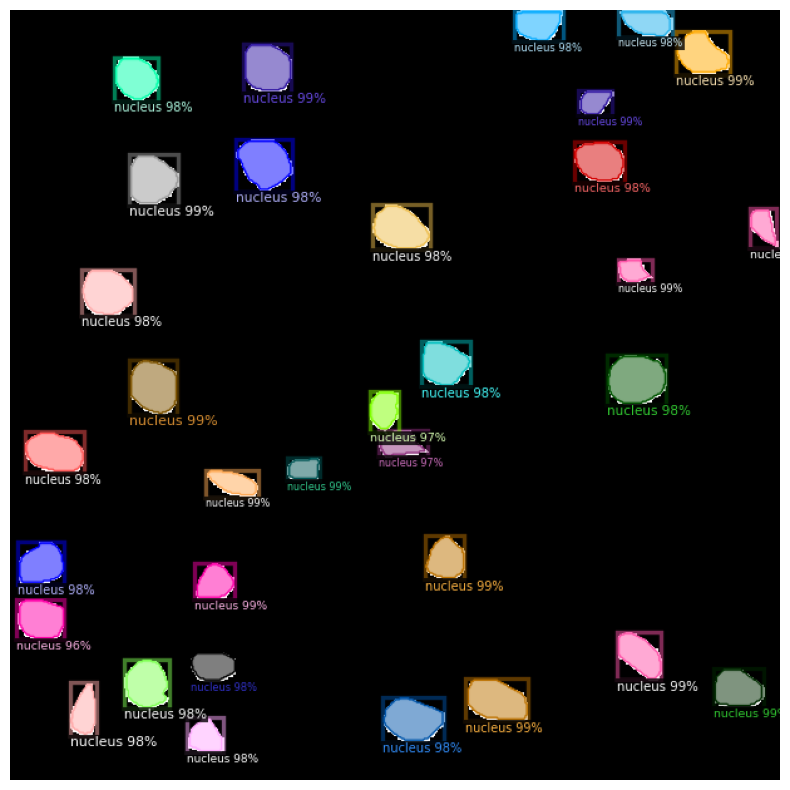

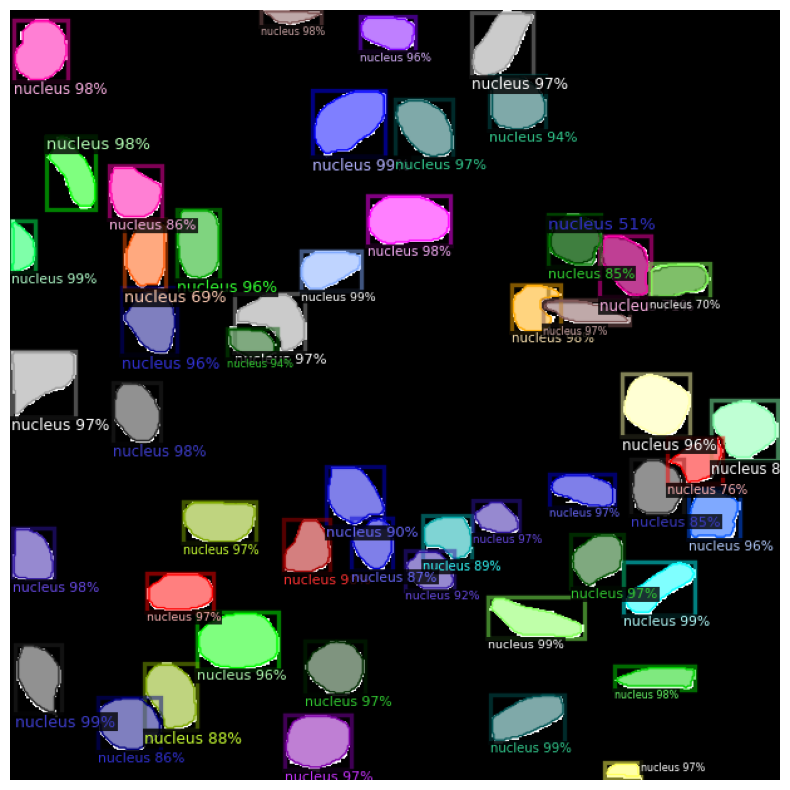

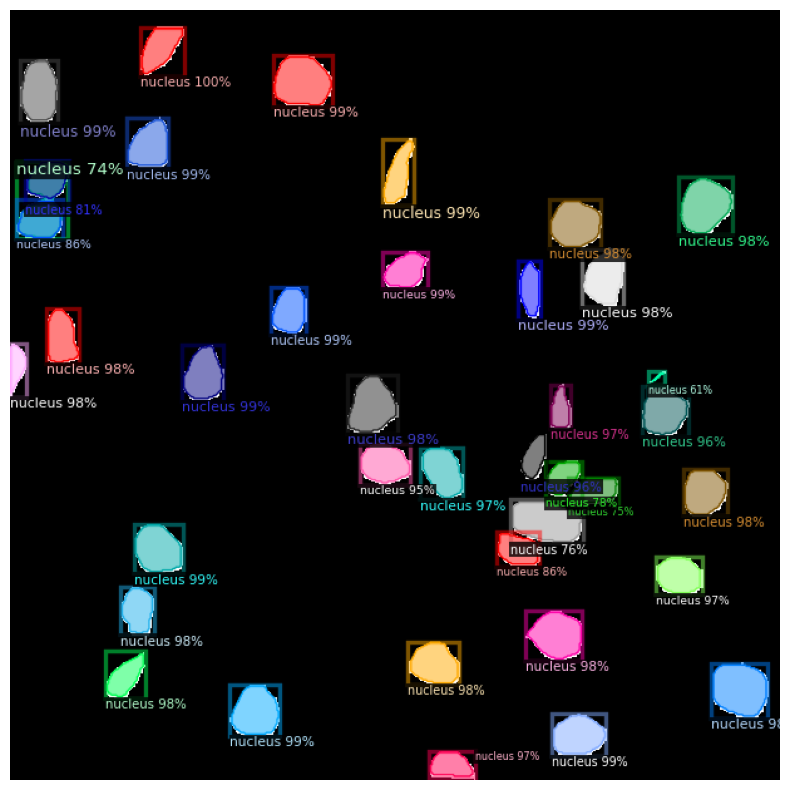

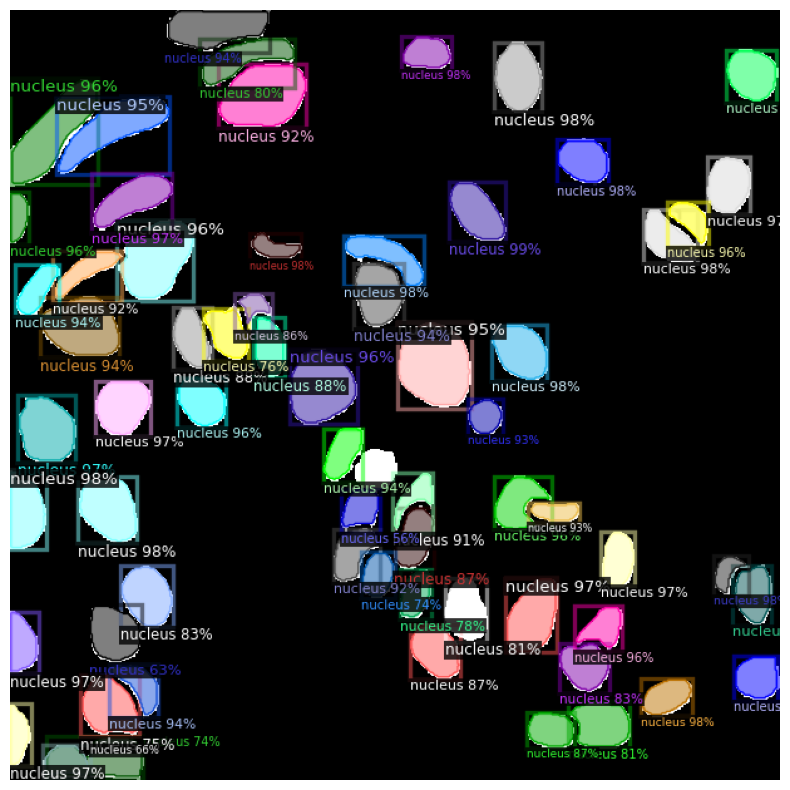

In [29]:
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Assuming `predictor` is already defined and configured

# Get dataset dictionary
dataset_dicts = DatasetCatalog.get("nuclei_val")

# Plot images and annotations
for d in random.sample(dataset_dicts, 5):
    # Read the image
    img = cv2.imread(d["file_name"])

    # Run inference
    outputs = predictor(img)

    # Visualize the result
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get("nuclei_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Convert image from BGR to RGB for matplotlib
    result_img = out.get_image()[:, :, ::-1]

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(result_img)
    plt.axis('off')  # Hide axes
    plt.show()


## `NOTEBOOK PRACTICE 12`

---
Modify the baseline notebook to get better performance.

---

### Instructions to Improve the Notebook (study and work about it by yourself):

ChatGPT can be your great allied. Use it for your convenence.

To improve the results of your Detectron2 training, you can apply several strategies that involve adjustments to hyperparameters, data augmentation, and the model architecture itself. Here are some key approaches:

### 1. **Hyperparameter Tuning**
   - **Learning Rate**: Start by adjusting the learning rate. Often, reducing the learning rate can lead to more stable convergence, particularly if you notice that the model's loss is fluctuating.
   - **Batch Size**: Increasing the batch size can lead to better generalization, but it also requires more memory. If possible, experiment with larger batch sizes.
   - **Number of Iterations**: Extend the number of training iterations if you observe that the model hasn't fully converged. Alternatively, use early stopping if the model begins to overfit.

### 2. **Data Augmentation**
   - **Random Cropping and Flipping**: Apply random cropping, flipping, rotation, or scaling to your training data. This can help the model generalize better by learning from diverse perspectives of the same objects.
   - **Color Jittering**: Introduce variations in color, brightness, contrast, and saturation. This forces the model to learn more robust features.
   - **Mixup and CutMix**: These techniques combine images during training, which can help in improving the robustness of the model by exposing it to hybrid examples.

### 3. **Model Architecture Adjustments**
   - **Backbone Network**: Experiment with different backbone architectures (e.g., ResNet-101, ResNeXt) that might offer better feature extraction for your specific dataset.
   - **Focal Loss**: If you're dealing with class imbalance, consider using Focal Loss instead of the standard cross-entropy loss to give more attention to harder-to-classify instances.
   - **Higher Resolution Input**: Training with higher-resolution images can capture finer details, improving the segmentation results. However, this will increase computational costs.

### 4. **Learning Rate Schedulers**
   - Use learning rate schedulers like `ReduceLROnPlateau`, which reduce the learning rate when a metric has stopped improving. This can help in fine-tuning the model during later stages of training.

### 5. **Transfer Learning**
   - If you're not already using pre-trained weights, consider initializing your model with weights from a model trained on a similar dataset (e.g., COCO). This can accelerate convergence and improve performance.

### 6. **Validation Strategy**
   - Implement cross-validation to better assess the model’s performance and reduce the likelihood of overfitting to a particular training set.

### 7. **Experiment Tracking**
   - Use tools like TensorBoard or Weights & Biases to track experiments, which can help you understand which changes positively impact your model's performance.

By applying these strategies, you can systematically improve the performance of your model. Remember, achieving better results often involves iterative experimentation and fine-tuning.


Happy coding!